In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, Dropout, LayerNormalization, Multiply, Reshape, Concatenate, Layer)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import RandomNormal, Orthogonal, Zeros
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
import random
import ast

In [9]:
df1=pd.read_csv('symtoms_df.csv')
df2=pd.read_csv('Symptom-severity.csv')

In [10]:
df1.head()

,Unnamed: 0,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4
0,0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches
1,1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN
2,2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN
3,3,Fungal infection,itching,skin_rash,dischromic _patches,NaN
4,4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN


In [11]:
df2.head()

,Symptom,weight
0,itching,1
1,skin_rash,3
2,nodal_skin_eruptions,4
3,continuous_sneezing,4
4,shivering,5


In [12]:
print(df2.to_markdown())

|     | Symptom                        |   weight |
|----:|:-------------------------------|---------:|
|   0 | itching                        |        1 |
|   1 | skin_rash                      |        3 |
|   2 | nodal_skin_eruptions           |        4 |
|   3 | continuous_sneezing            |        4 |
|   4 | shivering                      |        5 |
|   5 | chills                         |        3 |
|   6 | joint_pain                     |        3 |
|   7 | stomach_pain                   |        5 |
|   8 | acidity                        |        3 |
|   9 | ulcers_on_tongue               |        4 |
|  10 | muscle_wasting                 |        3 |
|  11 | vomiting                       |        5 |
|  12 | burning_micturition            |        6 |
|  13 | spotting_urination             |        6 |
|  14 | fatigue                        |        4 |
|  15 | weight_gain                    |        3 |
|  16 | anxiety                        |        4 |
|  17 | cold

In [13]:
df1['Symptom_4'].fillna('',inplace=True)

/tmp/ipykernel_79284/1593813174.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['Symptom_4'].fillna('',inplace=True)


In [14]:
df1['Symptoms']=df1['Symptom_1']+','+df1['Symptom_2']+','+df1['Symptom_3']+','+df1['Symptom_4']

In [15]:
df1=df1[['Symptoms','Disease']]

In [16]:
df1['Symptoms']=df1['Symptoms'].str.replace('_',' ')

In [17]:
df1.tail()

,Symptoms,Disease
4915,"vomiting, headache, nausea, spinning movements",(vertigo) Paroymsal Positional Vertigo
4916,"skin rash, pus filled pimples, blackheads, sc...",Acne
4917,"burning micturition, bladder discomfort, foul...",Urinary tract infection
4918,"skin rash, joint pain, skin peeling, silver l...",Psoriasis
4919,"skin rash, high fever, blister, red sore arou...",Impetigo


In [18]:
df2.tail()

,Symptom,weight
128,inflammatory_nails,2
129,blister,4
130,red_sore_around_nose,2
131,yellow_crust_ooze,3
132,prognosis,5


In [19]:
# Convert df2 into a dictionary: symptom -> weight
severity_dict = dict(zip(df2['Symptom'], df2['weight']))

In [20]:
# just want to check unique weights
set(severity_dict.values())

{1, 2, 3, 4, 5, 6, 7}

In [21]:
# --------------------------------------
# 3. Preprocess Symptoms from df1
# --------------------------------------
def preprocess_symptoms(symptom_str):
    """
    Converts comma-separated symptoms into a list of standardized tokens.
    1) Lowercase
    2) Trim spaces
    3) Replace inner spaces with underscores
    """
    # Split on commas
    symptoms = symptom_str.lower().split(',')
    # Clean each symptom token
    symptoms = [s.strip().replace(' ', '_') for s in symptoms]
    return symptoms

In [22]:
# Create a new column in df1 with the list of symptoms

df1['Symptom_list'] = df1['Symptoms'].apply(preprocess_symptoms)

In [23]:
df1.head()

,Symptoms,Disease,Symptom_list
0,"itching, skin rash, nodal skin eruptions, disc...",Fungal infection,"[itching, skin_rash, nodal_skin_eruptions, dis..."
1,"skin rash, nodal skin eruptions, dischromic ...",Fungal infection,"[skin_rash, nodal_skin_eruptions, dischromic__..."
2,"itching, nodal skin eruptions, dischromic pat...",Fungal infection,"[itching, nodal_skin_eruptions, dischromic__pa..."
3,"itching, skin rash, dischromic patches,",Fungal infection,"[itching, skin_rash, dischromic__patches, ]"
4,"itching, skin rash, nodal skin eruptions,",Fungal infection,"[itching, skin_rash, nodal_skin_eruptions, ]"


In [24]:
# ----------------------------------------------------
# 4. Tokenize the Symptoms (build a vocabulary)
# ----------------------------------------------------
# Flatten all symptom tokens to build a complete vocabulary

all_symptoms = [sym for row in df1['Symptom_list'] for sym in row]

tokenizer = Tokenizer(lower=True, filters='')  # no filters, since we've already cleaned
tokenizer.fit_on_texts(all_symptoms)


In [25]:
# ----------------------------------------------------
# 5. Convert Each List of Symptoms into Integer Sequences
# ----------------------------------------------------
# For each row, convert the list of symptom tokens into their integer IDs

df1['Symptom_seq'] = df1['Symptom_list'].apply(lambda x: tokenizer.texts_to_sequences(x))

# Flatten the list-of-lists for each row

df1['Symptom_seq'] = df1['Symptom_seq'].apply(lambda seq: [item for sublist in seq for item in sublist])


In [26]:
df1.head()

,Symptoms,Disease,Symptom_list,Symptom_seq
0,"itching, skin rash, nodal skin eruptions, disc...",Fungal infection,"[itching, skin_rash, nodal_skin_eruptions, dis...","[8, 5, 56, 57]"
1,"skin rash, nodal skin eruptions, dischromic ...",Fungal infection,"[skin_rash, nodal_skin_eruptions, dischromic__...","[5, 56, 57]"
2,"itching, nodal skin eruptions, dischromic pat...",Fungal infection,"[itching, nodal_skin_eruptions, dischromic__pa...","[8, 56, 57]"
3,"itching, skin rash, dischromic patches,",Fungal infection,"[itching, skin_rash, dischromic__patches, ]","[8, 5, 57]"
4,"itching, skin rash, nodal skin eruptions,",Fungal infection,"[itching, skin_rash, nodal_skin_eruptions, ]","[8, 5, 56]"


In [27]:
def shuffle_symptoms(row):
    """
    Takes a row with 'Symptoms', 'Symptom_list', and 'Symptom_seq'.
    Shuffles the symptom tokens (and corresponding token IDs) so that
    the mapping between symptom and token ID remains consistent.
    Returns new columns with the shuffled data.
    """
    # Pair each token with its corresponding token ID
    pairs = list(zip(row["Symptom_list"], row["Symptom_seq"]))

    # Shuffle the (token, token_id) pairs in place
    random.shuffle(pairs)

    # Unzip the shuffled pairs back into separate lists
    shuffled_symptoms, shuffled_seq = zip(*pairs)

    # Reconstruct the "Symptoms" string by joining shuffled tokens with commas
    shuffled_symptoms_str = ", ".join(shuffled_symptoms)

    # Return a Series containing the shuffled versions
    return pd.Series({
        "Shuffled_Symptoms": shuffled_symptoms_str,
        "Shuffled_Symptom_list": list(shuffled_symptoms),
        "Shuffled_Symptom_seq": list(shuffled_seq)
    })

In [28]:
# Apply the shuffle function row-by-row
df1[["Shuffled_Symptoms", "Shuffled_Symptom_list", "Shuffled_Symptom_seq"]] = df1.apply(shuffle_symptoms, axis=1)

# Display the Disease column as well as original and shuffled columns
df1[[
    "Symptoms", "Disease", "Symptom_list", "Symptom_seq",
    "Shuffled_Symptoms", "Shuffled_Symptom_list", "Shuffled_Symptom_seq"
]].head()
df1=df1.drop(columns={'Symptoms','Symptom_list','Symptom_seq'})

In [29]:
df1.head()

,Disease,Shuffled_Symptoms,Shuffled_Symptom_list,Shuffled_Symptom_seq
0,Fungal infection,"dischromic__patches, skin_rash, nodal_skin_eru...","[dischromic__patches, skin_rash, nodal_skin_er...","[57, 5, 56, 8]"
1,Fungal infection,"dischromic__patches, skin_rash, nodal_skin_eru...","[dischromic__patches, skin_rash, nodal_skin_er...","[57, 5, 56]"
2,Fungal infection,"dischromic__patches, itching, nodal_skin_erupt...","[dischromic__patches, itching, nodal_skin_erup...","[57, 8, 56]"
3,Fungal infection,"skin_rash, itching, dischromic__patches","[skin_rash, itching, dischromic__patches]","[5, 8, 57]"
4,Fungal infection,"nodal_skin_eruptions, skin_rash, itching","[nodal_skin_eruptions, skin_rash, itching]","[56, 5, 8]"


In [30]:
# ----------------------------------------------------
# 6. Pad the Sequences
# ----------------------------------------------------
max_length = max(df1['Shuffled_Symptom_seq'].apply(len))  # maximum length of any symptom sequence
X = pad_sequences(df1['Shuffled_Symptom_seq'], maxlen=max_length, padding='post', dtype='int32')



In [31]:
# ----------------------------------------------------
# 7. Encode Disease Labels
# ----------------------------------------------------
le = LabelEncoder()

y = le.fit_transform(df1['Disease'])

# Convert to one-hot vectors for a multi-class classification problem

y = tf.keras.utils.to_categorical(y)


In [32]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [33]:
# ----------------------------------------------------
# 8. Build a Weight Vector for the Vocabulary
# ----------------------------------------------------
# We'll create a numpy array, where each index corresponds to a token ID.
# If a token is found in severity_dict, use that weight; otherwise, default to 1.
vocab_size = len(tokenizer.word_index)
embedding_scaling = np.ones(vocab_size + 1, dtype=np.float32)  # +1 because index 0 is reserved (padding)

for token, index in tokenizer.word_index.items():
    if token in severity_dict:
        embedding_scaling[index] = severity_dict[token]
    else:
        embedding_scaling[index] = 1.0  # default severity weight

# Convert it to a constant tensor so it won't be trainable
embedding_scaling = tf.constant(embedding_scaling)


I0000 00:00:1744450872.862871   79284 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2560 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [34]:
np.unique(embedding_scaling)

array([1., 2., 3., 4., 5., 6., 7.], dtype=float32)

In [35]:
df1=df1[['Shuffled_Symptoms','Shuffled_Symptom_list','Shuffled_Symptom_seq','Disease']]
df1.head()

,Shuffled_Symptoms,Shuffled_Symptom_list,Shuffled_Symptom_seq,Disease
0,"dischromic__patches, skin_rash, nodal_skin_eru...","[dischromic__patches, skin_rash, nodal_skin_er...","[57, 5, 56, 8]",Fungal infection
1,"dischromic__patches, skin_rash, nodal_skin_eru...","[dischromic__patches, skin_rash, nodal_skin_er...","[57, 5, 56]",Fungal infection
2,"dischromic__patches, itching, nodal_skin_erupt...","[dischromic__patches, itching, nodal_skin_erup...","[57, 8, 56]",Fungal infection
3,"skin_rash, itching, dischromic__patches","[skin_rash, itching, dischromic__patches]","[5, 8, 57]",Fungal infection
4,"nodal_skin_eruptions, skin_rash, itching","[nodal_skin_eruptions, skin_rash, itching]","[56, 5, 8]",Fungal infection


In [36]:
df2.head()

,Symptom,weight
0,itching,1
1,skin_rash,3
2,nodal_skin_eruptions,4
3,continuous_sneezing,4
4,shivering,5


In [37]:
'''' Here you Need to Think of a New Approach How to deal with further  Shuffled_Symptom_seq and weights'''
'''one way is to put most weighted symptoms in last and least weighted symptoms first so that LSTM
   remembers High weighted one in the sequence in this weights also used and LSTM also works fine try this 
   Approach and see result
   in UI in First two selectbox user enters common symptoms and in last two most severe symptoms'''

'one way is to put most weighted symptoms in last and least weighted symptoms first so that LSTM\n   remembers High weighted one in the sequence in this weights also used and LSTM also works fine try this \n   Approach and see result\n   in UI in First two selectbox user enters common symptoms and in last two most severe symptoms'

In [38]:
''' Can we here think of New Model also despite LSTMs and RNNs --- Yes we use Some of the Attention Mechanism alse
    Rather than juss stick to RNN and LSTMs'''

' Can we here think of New Model also despite LSTMs and RNNs --- Yes we use Some of the Attention Mechanism alse\n    Rather than juss stick to RNN and LSTMs'

In [39]:
# Create a dictionary: {symptom: weight}
weight_map = dict(zip(df2["Symptom"], df2["weight"]))


In [40]:
weight_map

{'itching': 1,
 'skin_rash': 3,
 'nodal_skin_eruptions': 4,
 'continuous_sneezing': 4,
 'shivering': 5,
 'chills': 3,
 'joint_pain': 3,
 'stomach_pain': 5,
 'acidity': 3,
 'ulcers_on_tongue': 4,
 'muscle_wasting': 3,
 'vomiting': 5,
 'burning_micturition': 6,
 'spotting_urination': 6,
 'fatigue': 4,
 'weight_gain': 3,
 'anxiety': 4,
 'cold_hands_and_feets': 5,
 'mood_swings': 3,
 'weight_loss': 3,
 'restlessness': 5,
 'lethargy': 2,
 'patches_in_throat': 6,
 'irregular_sugar_level': 5,
 'cough': 4,
 'high_fever': 7,
 'sunken_eyes': 3,
 'breathlessness': 4,
 'sweating': 3,
 'dehydration': 4,
 'indigestion': 5,
 'headache': 3,
 'yellowish_skin': 3,
 'dark_urine': 4,
 'nausea': 5,
 'loss_of_appetite': 4,
 'pain_behind_the_eyes': 4,
 'back_pain': 3,
 'constipation': 4,
 'abdominal_pain': 4,
 'diarrhoea': 6,
 'mild_fever': 5,
 'yellow_urine': 4,
 'yellowing_of_eyes': 4,
 'acute_liver_failure': 6,
 'fluid_overload': 4,
 'swelling_of_stomach': 7,
 'swelled_lymph_nodes': 6,
 'malaise': 6,
 'bl

In [41]:
# For any symptom not in weight_map, use a default weight of 0
df1["Symptom_Weights"] = df1["Shuffled_Symptom_list"].apply(
    lambda sym_list: [weight_map.get(sym,1) for sym in sym_list]
)

In [42]:
df1.head()

,Shuffled_Symptoms,Shuffled_Symptom_list,Shuffled_Symptom_seq,Disease,Symptom_Weights
0,"dischromic__patches, skin_rash, nodal_skin_eru...","[dischromic__patches, skin_rash, nodal_skin_er...","[57, 5, 56, 8]",Fungal infection,"[1, 3, 4, 1]"
1,"dischromic__patches, skin_rash, nodal_skin_eru...","[dischromic__patches, skin_rash, nodal_skin_er...","[57, 5, 56]",Fungal infection,"[1, 3, 4]"
2,"dischromic__patches, itching, nodal_skin_erupt...","[dischromic__patches, itching, nodal_skin_erup...","[57, 8, 56]",Fungal infection,"[1, 1, 4]"
3,"skin_rash, itching, dischromic__patches","[skin_rash, itching, dischromic__patches]","[5, 8, 57]",Fungal infection,"[3, 1, 1]"
4,"nodal_skin_eruptions, skin_rash, itching","[nodal_skin_eruptions, skin_rash, itching]","[56, 5, 8]",Fungal infection,"[4, 3, 1]"


In [43]:
df2.weight.unique()

array([1, 3, 4, 5, 6, 2, 7])

In [44]:
df1=df1[['Shuffled_Symptoms','Shuffled_Symptom_list','Symptom_Weights','Disease']]

In [45]:
df1.tail()

,Shuffled_Symptoms,Shuffled_Symptom_list,Symptom_Weights,Disease
4915,"spinning_movements, nausea, headache, vomiting","[spinning_movements, nausea, headache, vomiting]","[6, 5, 3, 5]",(vertigo) Paroymsal Positional Vertigo
4916,"pus_filled_pimples, scurring, blackheads, skin...","[pus_filled_pimples, scurring, blackheads, ski...","[2, 2, 2, 3]",Acne
4917,"burning_micturition, bladder_discomfort, foul_...","[burning_micturition, bladder_discomfort, foul...","[6, 4, 1, 6]",Urinary tract infection
4918,"joint_pain, silver_like_dusting, skin_peeling,...","[joint_pain, silver_like_dusting, skin_peeling...","[3, 2, 3, 3]",Psoriasis
4919,"skin_rash, red_sore_around_nose, blister, high...","[skin_rash, red_sore_around_nose, blister, hig...","[3, 2, 4, 7]",Impetigo


In [46]:
df1.shape

(4920, 4)

In [47]:
df1[df1['Disease'].str.contains('Heart')].shape

(120, 4)

In [48]:
import ast

def safe_literal_eval(x):
    # If it's already a list, return it as-is.
    if isinstance(x, list):
        return x
    # Otherwise, try to evaluate the string representation
    try:
        return ast.literal_eval(x)
    except Exception as e:
        print(f"Error parsing {x}: {e}")
        return x

# Apply the safe evaluation function to the Symptom_Weights column.
df1['Symptom_Weights'] = df1['Symptom_Weights'].apply(safe_literal_eval)


In [49]:
df1['Symptom_Weights']

0       [1, 3, 4, 1]
1          [1, 3, 4]
2          [1, 1, 4]
3          [3, 1, 1]
4          [4, 3, 1]
            ...     
4915    [6, 5, 3, 5]
4916    [2, 2, 2, 3]
4917    [6, 4, 1, 6]
4918    [3, 2, 3, 3]
4919    [3, 2, 4, 7]
Name: Symptom_Weights, Length: 4920, dtype: object

In [50]:
# Process the symptoms: we assume they are a comma-separated string.
# If needed, you can further process (strip spaces, etc.)
df1['Symptom_Tokens'] = df1['Shuffled_Symptoms'].apply(lambda x: [sym.strip() for sym in x.split(',')])


In [51]:
# Determine maximum sequence length (number of symptoms per record)
max_len = df1['Symptom_Tokens'].apply(len).max()
max_len

np.int64(4)

In [52]:
# Prepare tokenizer on the symptom tokens
all_symptoms = df1['Symptom_Tokens'].tolist()
# Flatten the list of tokens
flat_symptoms = [sym for sublist in all_symptoms for sym in sublist]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(flat_symptoms)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

143


In [53]:
# Convert each record's symptom tokens to sequences of integers
df1['Symptom_Seq'] = df1['Symptom_Tokens'].apply(lambda tokens: tokenizer.texts_to_sequences(tokens))
# texts_to_sequences returns list of lists, so flatten each record
df1['Symptom_Seq'] = df1['Symptom_Seq'].apply(lambda seq_list: [item for sub in seq_list for item in sub])
# Pad sequences to uniform length (pad with zeros)
symptom_seqs = pad_sequences(df1['Symptom_Seq'], maxlen=max_len, padding='post')


In [54]:
symptom_seqs

array([[87,  4, 88, 13],
       [11, 87,  4, 88],
       [13, 87,  4, 88],
       ...,
       [23, 76,  5, 18],
       [ 4, 77,  4, 11],
       [84, 85,  7,  8]], dtype=int32)

In [55]:
# Similarly, pad the weights. We assume weights are given in order.
# If a record has fewer weights than max_len, pad with zeros.
weights = np.array([np.pad(w, (0, max_len - len(w)), 'constant') for w in df1['Symptom_Weights']])
weights

array([[1, 3, 4, 1],
       [1, 3, 4, 0],
       [1, 1, 4, 0],
       ...,
       [6, 4, 1, 6],
       [3, 2, 3, 3],
       [3, 2, 4, 7]])

In [56]:
# Encode the disease labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df1['Disease'])
num_classes = len(label_encoder.classes_)
labels_cat = to_categorical(labels, num_classes=num_classes)


In [57]:
# Train-test split
X_symptoms_train, X_symptoms_test, X_weights_train, X_weights_test, y_train, y_test = train_test_split(
    symptom_seqs, weights, labels_cat, test_size=0.2, random_state=42
)

In [58]:
# -------------------------
# 2. Build the LSTM Model
# -------------------------
embedding_dim = 512  # Adjust embedding size as needed


In [59]:
# Input layers
symptoms_input = Input(shape=(max_len,), name="symptoms_input")
weights_input = Input(shape=(max_len,), name="weights_input")


In [60]:
# Embedding layer for symptoms
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_len,
                            name="symptom_embedding")
embedded_symptoms = embedding_layer(symptoms_input)


/home/shashank/anaconda3/envs/tf-env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [61]:
# Reshape weights to multiply with embedding output
weights_reshaped = Reshape((max_len, 1), name="reshape_weights")(weights_input)
# Multiply embeddings by weights (element-wise multiplication)
weighted_embedding = Multiply(name="weighted_embedding")([embedded_symptoms, weights_reshaped])

In [62]:
weighted_embedding

<KerasTensor shape=(None, np.int64(4), 512), dtype=float32, sparse=False, ragged=False, name=keras_tensor_2>

In [63]:
# Reshape weights to match the dimensions of the embeddings (for element-wise multiplication)
weights_reshaped = Reshape((max_len, 1), name="reshape_weights")(weights_input)

# Multiply the embeddings by the corresponding weights
weighted_embedding = Multiply(name="weighted_embedding")([embedded_symptoms, weights_reshaped])

In [64]:
# LSTM layer with recurrent_dropout to force the fallback (non-cuDNN) implementation
lstm_out = LSTM(512, 
                activation='tanh', 
                recurrent_activation='sigmoid', 
                recurrent_dropout=0.2,  # This parameter forces the non-cuDNN kernel
                name="lstm_layer")(weighted_embedding)


In [65]:
# Add a dense layer for further processing
dense1 = Dense(128, activation='relu', name="dense_layer")(lstm_out)
# Output layer with softmax activation for multi-class classification
output = Dense(num_classes, activation='softmax', name="output_layer")(dense1)

In [66]:
# Build and compile the model
model = Model(inputs=[symptoms_input, weights_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ symptoms_input      │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weights_input       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ symptom_embedding   │ (None, 4, 512)    │     73,216 │ symptoms_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_weights     │ (None, 4, 1)      │          0 │ weights_input[0]… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weighted_embedding  │ (None, 4, 512)    │          0 │ symptom_embeddin… │
│ (Multiply)          │                   │            │ reshape_weights[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer (LSTM)   │ (None, 512)       │  2,099,200 │ weighted_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer (Dense) │ (None, 128)       │     65,664 │ lstm_layer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 41)        │      5,289 │ dense_layer[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,243,369 (8.56 MB)

 Trainable params: 2,243,369 (8.56 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# -------------------------
# 3. Train the Model
# -------------------------
batch_size = 32
epochs = 100  # Increase epochs if necessary

history = model.fit(
    [X_symptoms_train, X_weights_train], y_train,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6011 - loss: 2.0598 - val_accuracy: 0.9391 - val_loss: 0.2481
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9176 - loss: 0.2259 - val_accuracy: 0.9239 - val_loss: 0.2108
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9298 - loss: 0.1856 - val_accuracy: 0.9289 - val_loss: 0.2284
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9346 - loss: 0.1717 - val_accuracy: 0.9340 - val_loss: 0.1940
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9410 - loss: 0.1380 - val_accuracy: 0.9239 - val_loss: 0.1989
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9400 - loss: 0.1626 - val_accuracy: 0.9518 - val_loss: 0.1557
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9525 - loss: 0.1166 - val_accuracy: 0.9391 - val_loss: 0.1826
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9519 - loss: 0.1117 - 

Training Loss per Epoch: [1.0830178260803223, 0.21875503659248352, 0.18719279766082764, 0.15745414793491364, 0.15319404006004333, 0.1508530229330063, 0.12229066342115402, 0.11963298171758652, 0.11407046020030975, 0.10815343260765076, 0.11079342663288116, 0.10205645114183426, 0.10821212828159332, 0.09422022104263306, 0.0899670198559761, 0.09018604457378387, 0.08797375857830048, 0.0935760959982872, 0.08171256631612778, 0.08909013122320175, 0.0834713727235794, 0.07898030430078506, 0.07997448742389679, 0.09196992218494415, 0.1093437448143959, 0.09706194698810577, 0.08009596168994904, 0.08349788933992386, 0.08291264623403549, 0.07592872530221939, 0.07117072492837906, 0.08303602039813995, 0.09965499490499496, 0.08682779967784882, 0.07962619513273239, 0.0781397596001625, 0.06969721615314484, 0.06611645966768265, 0.06975080817937851, 0.07970930635929108, 0.08140679448843002, 0.07216545939445496, 0.06755562871694565, 0.06906858831644058, 0.06086354702711105, 0.06487488001585007, 0.0635850653052

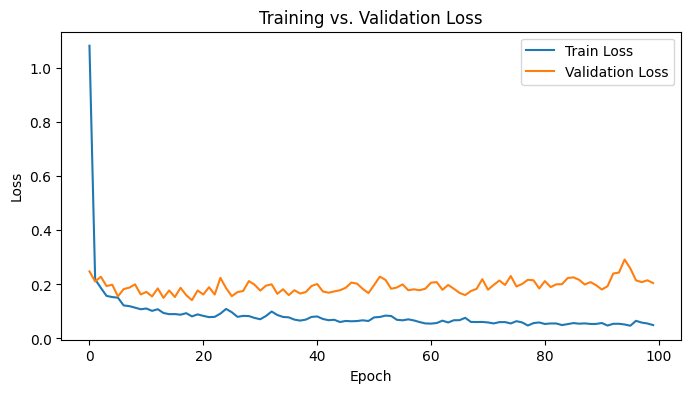

In [82]:
# ----------------------------------------------------------------
# Print and Plot Train vs. Validation Loss
# ----------------------------------------------------------------
train_loss = history.history['loss']
val_loss = history.history['val_loss']
print("Training Loss per Epoch:", train_loss)
print("Validation Loss per Epoch:", val_loss)

plt.figure(figsize=(8, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

Training Accuracy per Epoch: [0.7603049278259277, 0.9195370078086853, 0.9308300614356995, 0.939864456653595, 0.9381705522537231, 0.9387351870536804, 0.9505928754806519, 0.9474872946739197, 0.9477696418762207, 0.9548277854919434, 0.9522868394851685, 0.9568040370941162, 0.953698456287384, 0.9604743123054504, 0.9579333662986755, 0.9610389471054077, 0.9579333662986755, 0.9573687314987183, 0.962168276309967, 0.9587803483009338, 0.9610389471054077, 0.9613212943077087, 0.9613212943077087, 0.9579333662986755, 0.9568040370941162, 0.9579333662986755, 0.9630152583122253, 0.9632975459098816, 0.9632975459098816, 0.9649915099143982, 0.9661208391189575, 0.9627329111099243, 0.9610389471054077, 0.9607566595077515, 0.9627329111099243, 0.962168276309967, 0.9658384919166565, 0.9692264199256897, 0.9680970907211304, 0.9632975459098816, 0.9649915099143982, 0.9692264199256897, 0.9666854739189148, 0.9692264199256897, 0.9689440727233887, 0.969791054725647, 0.9683794379234314, 0.9692264199256897, 0.9689440727233

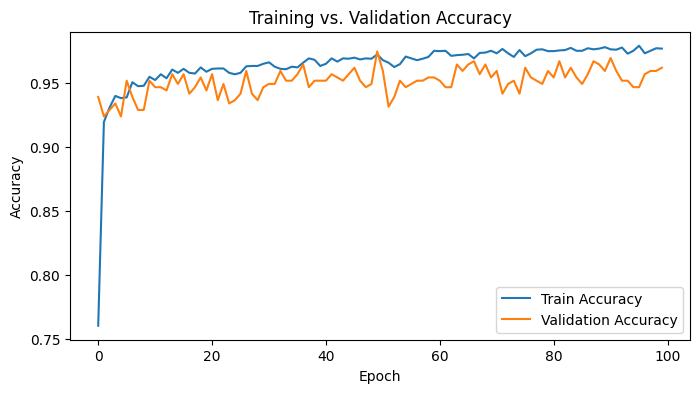

In [83]:
# ----------------------------------------------------------------
# Print and Plot Train vs. Validation Accuracy
# ----------------------------------------------------------------
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print("Training Accuracy per Epoch:", train_acc)
print("Validation Accuracy per Epoch:", val_acc)

plt.figure(figsize=(8, 4))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.show()

In [68]:
# -------------------------
# 4. Evaluate the Model
# -------------------------
loss, accuracy = model.evaluate([X_symptoms_test, X_weights_test], y_test, verbose=0)
print(f"Test Loss: {loss:.4f} | Test Accuracy: {accuracy:.4f}")


Test Loss: 0.2481 | Test Accuracy: 0.9472


In [ ]:
# -------------------------
# 5. Making Predictions
# -------------------------

# For making predictions on new data, make sure to preprocess the symptom tokens and weights similarly.

# Example:

new_symptoms = "fatigue ,weight_gain , anxiety"
new_weights = [5, 6, 7]
new_tokens = [sym.strip() for sym in new_symptoms.split(',')]
new_seq = tokenizer.texts_to_sequences(new_tokens)
new_seq = [item for sub in new_seq for item in sub]
new_seq = pad_sequences([new_seq], maxlen=max_len, padding='post')
new_weights = np.array([np.pad(new_weights, (0, max_len - len(new_weights)), 'constant')])
prediction = model.predict([new_seq, new_weights])
predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
print("Predicted Disease:", predicted_label[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Disease: Hypothyroidism


*********************************** Using Attention Layer *********************************************************

In [91]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, Dropout, Multiply, Reshape, LayerNormalization, GlobalAveragePooling1D
)
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [92]:
embedding_dim = 512  # dimension for symptom embeddings

# ---------------------------
# Build the Enhanced Model Architecture with Multiple Attention Layers
# ---------------------------

# Input layers for the symptom sequences and their associated weights
symptoms_input = Input(shape=(max_len,), name="symptoms_input")
weights_input = Input(shape=(max_len,), name="weights_input")

# Embedding layer for symptoms
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_len,
                            name="symptom_embedding")
embedded_symptoms = embedding_layer(symptoms_input)

# Reshape the weights so they are compatible for element-wise multiplication
weights_reshaped = Reshape((max_len, 1), name="reshape_weights")(weights_input)

# Multiply the symptom embeddings by their weights
weighted_embedding = Multiply(name="weighted_embedding")([embedded_symptoms, weights_reshaped])

# LSTM layer that outputs a hidden state for each time step
lstm_out = LSTM(512,
                activation='tanh',
                recurrent_activation='sigmoid',
                recurrent_dropout=0.2,
                return_sequences=True,
                name="lstm_layer")(weighted_embedding)

/home/shashank/anaconda3/envs/tf-env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [93]:
# ----------------------------------------
# First Multi-Head Attention Block
# ----------------------------------------
# Use the LSTM outputs as the query, key and value.
attention_1 = MultiHeadAttention(num_heads=8, key_dim=64, name="multihead_attention_1")(
    query=lstm_out,
    value=lstm_out,
    key=lstm_out
)
# Apply a residual connection followed by layer normalization.
attn_out_1 = tf.keras.layers.Add(name="residual_1")([lstm_out, attention_1])
attn_norm_1 = LayerNormalization(epsilon=1e-6, name="layer_norm_1")(attn_out_1)


In [94]:
# ----------------------------------------
# Second Multi-Head Attention Block
# ----------------------------------------
# A second block refines the features further.
attention_2 = MultiHeadAttention(num_heads=8, key_dim=64, name="multihead_attention_2")(
    query=attn_norm_1,
    value=attn_norm_1,
    key=attn_norm_1
)
# Again, use a residual connection and layer normalization.
attn_out_2 = tf.keras.layers.Add(name="residual_2")([attn_norm_1, attention_2])
attn_norm_2 = LayerNormalization(epsilon=1e-6, name="layer_norm_2")(attn_out_2)

# Optionally, aggregate the sequence of features into one single vector.
# Here we use global average pooling.
global_context = GlobalAveragePooling1D(name="global_avg_pool")(attn_norm_2)

# A dropout can be added before feeding the representation to dense layers.
drop = Dropout(0.5, name="dropout_layer")(global_context)

# Fully-connected layer for additional processing.
dense1 = Dense(128, activation='relu', name="dense_layer")(drop)

# Output layer with softmax for multi-class classification.
output = Dense(num_classes, activation='softmax', name="output_layer")(dense1)

# Build and compile the enhanced model.
model_enhanced = Model(inputs=[symptoms_input, weights_input], outputs=output)
model_enhanced.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary.
model_enhanced.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ symptoms_input      │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weights_input       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ symptom_embedding   │ (None, 4, 512)    │     73,216 │ symptoms_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_weights     │ (None, 4, 1)      │          0 │ weights_input[0]… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weighted_embedding  │ (None, 4, 512)    │          0 │ symptom_embeddin… │
│ (Multiply)          │                   │            │ reshape_weights[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer (LSTM)   │ (None, 4, 512)    │  2,099,200 │ weighted_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attentio… │ (None, 4, 512)    │  1,050,624 │ lstm_layer[0][0], │
│ (MultiHeadAttentio… │                   │            │ lstm_layer[0][0], │
│                     │                   │            │ lstm_layer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_1 (Add)    │ (None, 4, 512)    │          0 │ lstm_layer[0][0], │
│                     │                   │            │ multihead_attent… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm_1        │ (None, 4, 512)    │      1,024 │ residual_1[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attentio… │ (None, 4, 512)    │  1,050,624 │ layer_norm_1[0][… │
│ (MultiHeadAttentio… │                   │            │ layer_norm_1[0][… │
│                     │                   │            │ layer_norm_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_2 (Add)    │ (None, 4, 512)    │          0 │ layer_norm_1[0][… │
│                     │                   │            │ multihead_attent… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm_2        │ (None, 4, 512)    │      1,024 │ residual_2[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg_pool     │ (None, 512)       │          0 │ layer_norm_2[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_layer       │ (None, 512)       │          0 │ global_avg_pool[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer (Dense) │ (None, 128)       │     65,664 │ dropout_layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 41)        │      5,289 │ dense_layer[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,346,665 (16.58 MB)

 Trainable params: 4,346,665 (16.58 MB)

 Non-trainable params: 0 (0.00 B)

In [95]:
# -------------------------
# Train the Enhanced Model
# -------------------------
batch_size = 32
epochs = 100  # Increase if needed

history_enhanced = model_enhanced.fit(
    [X_symptoms_train, X_weights_train], y_train,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.5980 - loss: 1.5295 - val_accuracy: 0.8452 - val_loss: 0.5153
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8558 - loss: 0.4430 - val_accuracy: 0.8731 - val_loss: 0.3508
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9029 - loss: 0.2879 - val_accuracy: 0.9112 - val_loss: 0.2649
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8992 - loss: 0.2806 - val_accuracy: 0.9162 - val_loss: 0.2580
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9188 - loss: 0.2519 - val_accuracy: 0.9010 - val_loss: 0.3087
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9147 - loss: 0.2472 - val_accuracy: 0.9213 - val_loss: 0.2461
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9264 - loss: 0.2066 - val_accuracy: 0.9213 - val_loss: 0.3038
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9165 - loss: 0.2330 - 

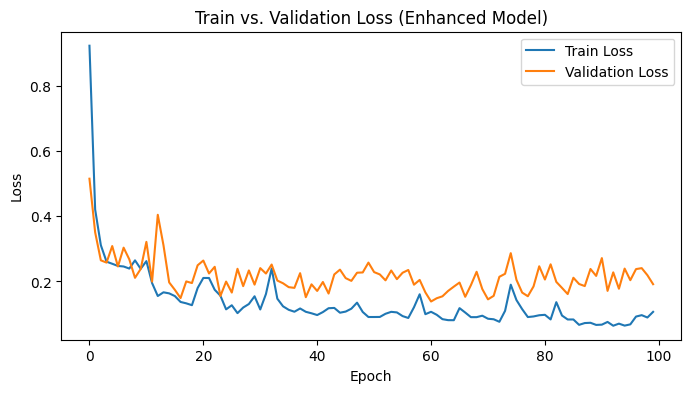

In [96]:
# ----------------------------------------------------------------
# Plot Train vs. Validation Loss for Enhanced Model
# ----------------------------------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(history_enhanced.history['loss'], label='Train Loss')
plt.plot(history_enhanced.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs. Validation Loss (Enhanced Model)')
plt.legend()
plt.show()

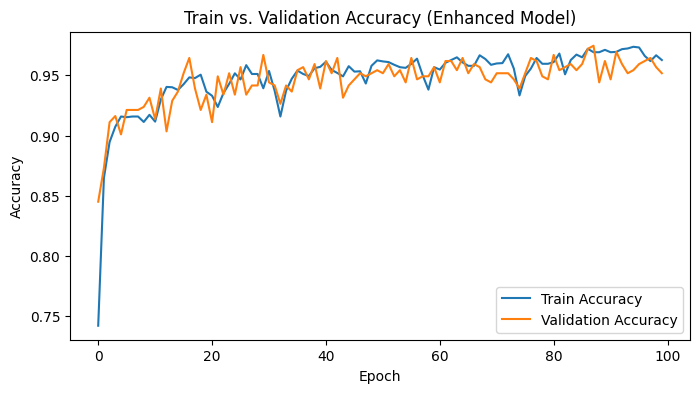

In [97]:
# ----------------------------------------------------------------
# Plot Train vs. Validation Accuracy for Enhanced Model
# ----------------------------------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(history_enhanced.history['accuracy'], label='Train Accuracy')
plt.plot(history_enhanced.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs. Validation Accuracy (Enhanced Model)')
plt.legend()
plt.show()

In [98]:
# -------------------------
# Evaluate the Enhanced Model
# -------------------------
loss_enhanced, accuracy_enhanced = model_enhanced.evaluate([X_symptoms_test, X_weights_test], y_test, verbose=0)
print(f"Enhanced Model --> Test Loss: {loss_enhanced:.4f} | Test Accuracy: {accuracy_enhanced:.4f}")


Enhanced Model --> Test Loss: 0.2800 | Test Accuracy: 0.9309


In [99]:
# -------------------------
# Making Predictions with the Enhanced Model
# -------------------------
# Example of prediction: preprocess the input the same as training data
new_symptoms = "fatigue ,weight_gain , anxiety"
new_weights = [5, 6, 7]
new_tokens = [sym.strip() for sym in new_symptoms.split(',')]
new_seq = tokenizer.texts_to_sequences(new_tokens)
new_seq = [item for sub in new_seq for item in sub]
new_seq = pad_sequences([new_seq], maxlen=max_len, padding='post')
new_weights = np.array([np.pad(new_weights, (0, max_len - len(new_weights)), 'constant')])
prediction_enhanced = model_enhanced.predict([new_seq, new_weights])
predicted_label_enhanced = label_encoder.inverse_transform([np.argmax(prediction_enhanced)])
print("Predicted Disease (Enhanced Model):", predicted_label_enhanced[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
Predicted Disease (Enhanced Model): Hypothyroidism


******************************************** Using LSTMs + SVM Hybrid **********************************************

In [139]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, LSTM, Dense, Multiply,
                                     Reshape, Layer)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import ast

In [140]:
# 1. Load Data
df1 = pd.read_csv('symtoms_df.csv')
df2 = pd.read_csv('Symptom-severity.csv')

# 2. Process the Symptoms DataFrame
df1['Symptom_4'].fillna('', inplace=True)
df1['Symptoms'] = df1['Symptom_1'] + ',' + df1['Symptom_2'] + ',' + df1['Symptom_3'] + ',' + df1['Symptom_4']
df1 = df1[['Symptoms', 'Disease']]
df1['Symptoms'] = df1['Symptoms'].str.replace('_', ' ')

# 3. Process the Severity DataFrame and build weight dictionary
severity_dict = dict(zip(df2['Symptom'], df2['weight']))


/tmp/ipykernel_79284/3257320669.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['Symptom_4'].fillna('', inplace=True)


In [141]:
# Preprocessing function for symptom tokens
def preprocess_symptoms(symptom_str):
    symptoms = symptom_str.lower().split(',')
    symptoms = [s.strip().replace(' ', '_') for s in symptoms]
    return symptoms

In [142]:
# Create symptom list column
df1['Symptom_list'] = df1['Symptoms'].apply(preprocess_symptoms)

# Tokenize the symptoms (build a vocabulary)
all_symptoms = [sym for row in df1['Symptom_list'] for sym in row]
tokenizer = Tokenizer(lower=True, filters='')  # already cleaned
tokenizer.fit_on_texts(all_symptoms)

# Convert each list of symptoms into integer sequences
df1['Symptom_seq'] = df1['Symptom_list'].apply(lambda x: tokenizer.texts_to_sequences(x))
df1['Symptom_seq'] = df1['Symptom_seq'].apply(lambda seq: [item for sublist in seq for item in sublist])


In [143]:
# Optionally shuffle symptoms within each row
def shuffle_symptoms(row):
    pairs = list(zip(row["Symptom_list"], row["Symptom_seq"]))
    random.shuffle(pairs)
    shuffled_symptoms, shuffled_seq = zip(*pairs)
    shuffled_symptoms_str = ", ".join(shuffled_symptoms)
    return pd.Series({
        "Shuffled_Symptoms": shuffled_symptoms_str,
        "Shuffled_Symptom_list": list(shuffled_symptoms),
        "Shuffled_Symptom_seq": list(shuffled_seq)
    })

In [144]:
df1[["Shuffled_Symptoms", "Shuffled_Symptom_list", "Shuffled_Symptom_seq"]] = df1.apply(shuffle_symptoms, axis=1)
df1 = df1.drop(columns=['Symptoms','Symptom_list','Symptom_seq'])


In [145]:
# Build weight mapping for each symptom token:
weight_map = dict(zip(df2["Symptom"], df2["weight"]))
df1["Symptom_Weights"] = df1["Shuffled_Symptom_list"].apply(
    lambda sym_list: [weight_map.get(sym, 1) for sym in sym_list]
)

In [146]:
# For further processing, create tokens by splitting the shuffled string.
df1['Symptom_Tokens'] = df1['Shuffled_Symptoms'].apply(lambda x: [sym.strip() for sym in x.split(',')])

# 4. Prepare Tokenizer on the new symptom tokens and convert to sequences
# Set a fixed maximum sequence length. Here we choose 20 for consistency.
max_len = 20


In [147]:
# Create tokenizer over symptom tokens (if needed, you could re-use the one above)
all_tokens = df1['Symptom_Tokens'].tolist()
flat_tokens = [sym for sublist in all_tokens for sym in sublist]
tokenizer_tokens = Tokenizer()
tokenizer_tokens.fit_on_texts(flat_tokens)
vocab_size = len(tokenizer_tokens.word_index) + 1


In [148]:
# Convert each record's symptom tokens to sequences and flatten list-of-lists
df1['Symptom_Seq'] = df1['Symptom_Tokens'].apply(lambda tokens: tokenizer_tokens.texts_to_sequences(tokens))
df1['Symptom_Seq'] = df1['Symptom_Seq'].apply(lambda seq_list: [item for sub in seq_list for item in sub])


In [149]:
# Pad symptom sequences to max_len tokens
symptom_seqs = pad_sequences(df1['Symptom_Seq'], maxlen=max_len, padding='post')

# Similarly, pad the weights array (pad with zeros if needed)
weights = np.array([np.pad(w, (0, max_len - len(w)), 'constant') for w in df1['Symptom_Weights']])

# Encode the disease labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df1['Disease'])
num_classes = len(label_encoder.classes_)
labels_cat = to_categorical(labels, num_classes=num_classes)

# Train-test split
X_symptoms_train, X_symptoms_test, X_weights_train, X_weights_test, y_train, y_test = train_test_split(
    symptom_seqs, weights, labels_cat, test_size=0.2, random_state=42
)

In [150]:
# -------------------------------------
# 5. Build the LSTM + Attention Feature Extractor Model
# -------------------------------------
# Custom Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        # input_shape: (batch_size, time_steps, hidden_size)
        self.W = self.add_weight(name="att_weight", 
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", 
                                 shape=(input_shape[-1],),
                                 initializer="zeros")
        self.u = self.add_weight(name="context_vector", 
                                 shape=(input_shape[-1],),
                                 initializer="normal")
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, x):
        # x shape: (batch_size, time_steps, hidden_size)
        v = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)  # (batch_size, time_steps, hidden_size)
        vu = tf.tensordot(v, self.u, axes=1)  # (batch_size, time_steps)
        alphas = tf.nn.softmax(vu)  # (batch_size, time_steps)
        # Compute weighted sum of the LSTM outputs
        output = tf.reduce_sum(x * tf.expand_dims(alphas, -1), axis=1)
        return output

In [151]:
# Hyperparameters for the neural network
embedding_dim = 512

# Define input layers. Notice we use max_len (20) as the input shape.
symptoms_input = Input(shape=(max_len,), name="symptoms_input")
weights_input = Input(shape=(max_len,), name="weights_input")

# Embedding layer for symptoms tokens
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_len,
                            name="symptom_embedding")
embedded_symptoms = embedding_layer(symptoms_input)


/home/shashank/anaconda3/envs/tf-env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [152]:
# Reshape weights to allow element-wise multiplication with embeddings
weights_reshaped = Reshape((max_len, 1), name="reshape_weights")(weights_input)
weighted_embedding = Multiply(name="weighted_embedding")([embedded_symptoms, weights_reshaped])


In [153]:
# LSTM layer with return_sequences=True for attention; with recurrent dropout
lstm_out = LSTM(512,
                activation='tanh',
                recurrent_activation='sigmoid',
                recurrent_dropout=0.2,
                return_sequences=True,
                name="lstm_layer")(weighted_embedding)


In [154]:
# Apply the custom Attention layer to get a fixed-length feature vector
attention_out = AttentionLayer(name="attention_layer")(lstm_out)

# Dense layer to obtain final feature representation
features = Dense(128, activation='relu', name="feature_dense")(attention_out)

# Dummy output layer (softmax) to allow end-to-end training.
dummy_output = Dense(num_classes, activation='softmax', name="dummy_output")(features)

# Build the model for training the feature extractor
feature_extractor_model = Model(inputs=[symptoms_input, weights_input], outputs=dummy_output)
feature_extractor_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
feature_extractor_model.summary()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ symptoms_input      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weights_input       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ symptom_embedding   │ (None, 20, 512)   │     73,216 │ symptoms_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_weights     │ (None, 20, 1)     │          0 │ weights_input[0]… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weighted_embedding  │ (None, 20, 512)   │          0 │ symptom_embeddin… │
│ (Multiply)          │                   │            │ reshape_weights[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer (LSTM)   │ (None, 20, 512)   │  2,099,200 │ weighted_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 512)       │    263,168 │ lstm_layer[0][0]  │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_dense       │ (None, 128)       │     65,664 │ attention_layer[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dummy_output        │ (None, 41)        │      5,289 │ feature_dense[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,506,537 (9.56 MB)

 Trainable params: 2,506,537 (9.56 MB)

 Non-trainable params: 0 (0.00 B)

In [155]:
# Train the model
batch_size = 32
epochs = 100  # Adjust as necessary

history_attention = feature_extractor_model.fit(
    [X_symptoms_train, X_weights_train], y_train,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.4633 - loss: 2.3309 - val_accuracy: 0.9213 - val_loss: 0.2549
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.9036 - loss: 0.2537 - val_accuracy: 0.9086 - val_loss: 0.2643
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.9345 - loss: 0.1875 - val_accuracy: 0.9239 - val_loss: 0.2066
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9257 - loss: 0.1716 - val_accuracy: 0.9315 - val_loss: 0.1812
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.9390 - loss: 0.1495 - val_accuracy: 0.9315 - val_loss: 0.2152
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9470 - loss: 0.1420 - val_accuracy: 0.9289 - val_loss: 0.1630
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9452 - loss: 0.1342 - val_accuracy: 0.9594 - val_loss: 0.1265
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9458 - loss: 0.1328 - 

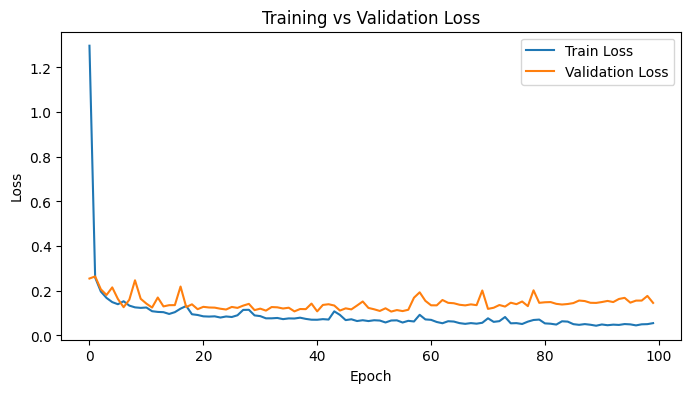

In [156]:
# Plot training history (Loss and Accuracy)
train_loss = history_attention.history['loss']
val_loss = history_attention.history['val_loss']
plt.figure(figsize=(8, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

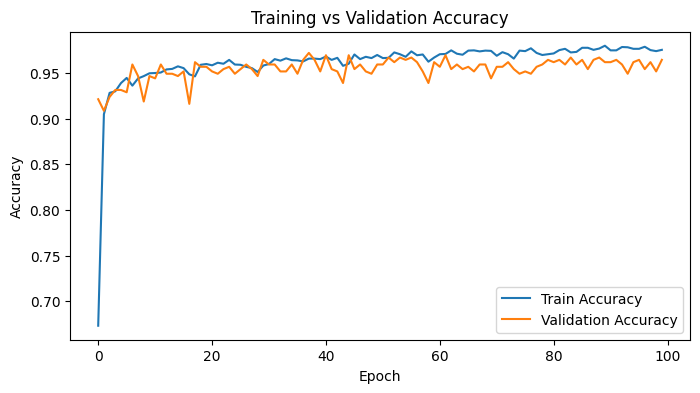

In [157]:
train_acc = history_attention.history['accuracy']
val_acc = history_attention.history['val_accuracy']
plt.figure(figsize=(8, 4))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

In [158]:
loss_att, acc_att = feature_extractor_model.evaluate([X_symptoms_test, X_weights_test], y_test, verbose=0)
print(f"LSTM+Attention Model Evaluation -- Loss: {loss_att:.4f} | Accuracy: {acc_att:.4f}")


LSTM+Attention Model Evaluation -- Loss: 0.1619 | Accuracy: 0.9654


In [159]:
# -------------------------------------
# 6. Extract Features and Train an SVM Classifier
# -------------------------------------
# Create a new model that outputs the 128-dimensional features from the Dense layer.
feature_extractor = Model(inputs=[symptoms_input, weights_input], outputs=features)

# Extract feature vectors from training and testing data.
train_features = feature_extractor.predict([X_symptoms_train, X_weights_train])
test_features = feature_extractor.predict([X_symptoms_test, X_weights_test])


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [160]:
# Train the SVM classifier on the extracted features.
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

svm_classifier = SVC(probability=True)  # Enable probability estimates if needed
svm_classifier.fit(train_features, np.argmax(y_train, axis=1))

# Evaluate the SVM classifier on the test set.
svm_preds = svm_classifier.predict(test_features)
svm_accuracy = accuracy_score(np.argmax(y_test, axis=1), svm_preds)
print("SVM Classifier Test Accuracy: {:.4f}".format(svm_accuracy))
print("Classification Report:\n", classification_report(np.argmax(y_test, axis=1), svm_preds))


SVM Classifier Test Accuracy: 0.9634
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        24
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00        23
           6       0.92      1.00      0.96        33
           7       1.00      0.96      0.98        23
           8       1.00      0.90      0.95        21
           9       0.82      0.93      0.88        15
          10       1.00      0.96      0.98        23
          11       1.00      0.96      0.98        26
          12       1.00      1.00      1.00        21
          13       1.00      1.00      1.00        29
          14       1.00      1.00      1.00        24
          15       1.00      1.00      1.00        19
          16       1

In [161]:
# -------------------------------------
# 7. Making Predictions on New Data
# -------------------------------------
# Example new input data.
new_symptoms = "fatigue, weight_gain, anxiety"
new_weights = [5, 6, 7]  # Example weights corresponding to the symptoms

# Preprocess new data tokens in the same way.
new_tokens = [sym.strip() for sym in new_symptoms.split(',')]
new_seq = tokenizer_tokens.texts_to_sequences(new_tokens)
new_seq = [item for sub in new_seq for item in sub]
new_seq = pad_sequences([new_seq], maxlen=max_len, padding='post')

# Pad new weights to match max_len.
new_weights = np.array([np.pad(new_weights, (0, max_len - len(new_weights)), 'constant')])

# Extract feature representation from new data.
new_feature = feature_extractor.predict([new_seq, new_weights])

# Predict the disease using the trained SVM classifier.
svm_prediction = svm_classifier.predict(new_feature)
predicted_label = label_encoder.inverse_transform(svm_prediction)
print("Predicted Disease (Hybrid Model):", predicted_label[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Disease (Hybrid Model): Hypothyroidism
